In [ ]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 2 — Basics of Data and Preprocessing
## Lesson 6: Feature Engineering Fundamentals

Feature engineering is the disciplined craft of turning *raw signals* into *model-ready inputs* that express the structure of your problem. In tabular machine learning, this step is often where most of the performance, stability, and interpretability gains come from.

A compact way to describe the idea is:

- Raw input: $x_{\mathrm{raw}}$
- Feature map: $\phi(\cdot)$
- Model prediction: $$\hat{y} = f_{\theta}\!\left(\phi(x_{\mathrm{raw}})\right)$$

Even if you ultimately use powerful learners, a well-designed $\phi(\cdot)$ can make learning easier, reduce the sample complexity, and prevent common failure modes (especially leakage).

### What you will learn (practical outcomes)
By the end of this lesson you will be able to:

1. Identify which feature transformations change the *hypothesis class* (and therefore model capacity).
2. Engineer numeric, categorical, datetime, text, and group-aggregate features with correct train/test hygiene.
3. Detect and avoid leakage patterns that feature engineering can accidentally introduce.
4. Build an end-to-end `scikit-learn` pipeline that keeps engineering steps reproducible and safe.
5. Evaluate whether engineered features actually help (rather than just adding complexity).

We will demonstrate techniques on **multiple datasets** (classification + regression + mixed-type tabular) to practice choosing features rather than memorizing a single recipe.


## 1) A mental model: features define what the model can represent

When you choose a model family you choose a *hypothesis class*. But feature engineering can be just as important because it changes the “language” the model sees.

For example, a linear model on engineered features is:

$$\hat{y} = w^\top \phi(x) + b$$

Even if $w$ is linear, $\phi(\cdot)$ can introduce nonlinearity through:
- products ($x_1 x_2$),
- ratios ($x_1/(x_2+\epsilon)$),
- polynomials ($x_1^2$),
- piecewise bins (bucketized features),
- logarithms ($\log(1+x)$),
- and many more.

### Three practical questions to ask before engineering
1. **What invariances should the model respect?** (e.g., scale invariance → ratios/logs)
2. **What monotonic or structural relationships are plausible?** (e.g., increasing risk with dose)
3. **Where is leakage likely to hide?** (e.g., post-outcome variables, “future” aggregates)

In the rest of the notebook we will use these questions as a checklist while creating features.


## 2) What makes a “good” engineered feature?

A useful engineered feature tends to satisfy at least one of these properties:

- **Predictive**: it correlates with the target because it captures a causal proxy or a stable association.
- **Stable**: it is not overly sensitive to noise, outliers, or rare categories.
- **Computable at inference time**: you can compute it from information available when you actually deploy.
- **Low leakage risk**: it does not sneak in post-outcome signals or aggregates that use future data.
- **Low operational cost**: it is not fragile, expensive, or hard to maintain.
- **Model-aligned**: it matches what your model family is good at (e.g., linear models like “linear-ish” relationships).

A practical way to think: feature engineering is a negotiation between *domain structure* and *model bias*.

### Examples of “model-aligned” feature choices
- For linear / generalized linear models: log transforms, ratios, interactions, monotone re-parameterizations.
- For trees: bins are less important, but missing indicators and meaningful splits can help.
- For distance-based models (kNN, RBF kernels): scaling and “metric learning by features” is critical.
- For naive Bayes / count models: counts, rates, and calibrated discretizations can simplify assumptions.


## 3) Data we will use in this lesson

To practice *feature choice*, we will touch multiple real-world-shaped tables:

- **Health / classification** (diabetes-style numeric measurements)
- **E-commerce / regression** (diamonds with categorical quality attributes + numeric measurements)
- **Housing / regression** (house prices with neighborhood structure)
- **Geo + text** (fast food places with categories + latitude/longitude)
- **Time series events** (earthquake timestamps)
- **Marketplace listings** (group structure: neighborhoods, hosts)
- **HR-style table** (salary with job titles)

In a real project you would typically run feature engineering on the full CSV files in the repository. Here we will work with small excerpts to keep transformations readable, and we will generate larger *toy* tables by resampling + noise so that model evaluation is meaningful.


## 4) Setup

We will use:
- `pandas` / `numpy` for table manipulation,
- `scikit-learn` for preprocessing pipelines and evaluation.

We will fix random seeds for reproducibility of the *examples*.


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, PolynomialFeatures,
    PowerTransformer, QuantileTransformer, KBinsDiscretizer,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import matplotlib.pyplot as plt

np.random.seed(7)

In [2]:
# Load datasets from the repository paths (if present). Otherwise use small embedded excerpts.

from pathlib import Path

def load_csv_or_fallback(path, fallback_df):
    p = Path(path)
    if p.exists():
        return pd.read_csv(p)
    return fallback_df.copy()

diabetes_fallback = pd.DataFrame([
    [6,148,72,35,0,33.6,0.627,50,"Diabetic"],
    [1,85,66,29,0,26.6,0.351,31,"Non-Diabetic"],
    [8,183,64,0,0,23.3,0.672,32,"Diabetic"],
    [1,89,66,23,94,28.1,0.167,21,"Non-Diabetic"],
    [0,137,40,35,168,43.1,2.288,33,"Diabetic"],
], columns=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","classification"])

diamonds_fallback = pd.DataFrame([
    [1,0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43],
    [2,0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31],
    [3,0.23,"Good","E","VS1",56.9,65,327,4.05,4.07,2.31],
    [4,0.29,"Premium","I","VS2",62.4,58,334,4.20,4.23,2.63],
    [5,0.31,"Good","J","SI2",63.3,58,335,4.34,4.35,2.75],
    [6,0.24,"Very Good","J","VVS2",62.8,57,336,3.94,3.96,2.48],
], columns=["id","carat","cut","color","clarity","depth","table","price","x","y","z"])

house_prices_fallback = pd.DataFrame([
    [1,114300,1790,2,2,2,"No","East"],
    [2,114200,2030,4,2,3,"No","East"],
    [3,114800,1740,3,2,1,"No","East"],
    [4,94700,1980,3,2,3,"No","East"],
    [5,119800,2130,3,3,3,"No","East"],
], columns=["Home","Price","SqFt","Bedrooms","Bathrooms","Offers","Brick","Neighborhood"])

salaries_fallback = pd.DataFrame([
    ["Kevin Sanders",24,"Software Engineer",7300],
    ["Lisa Mills",26,"High School Teacher",6100],
    ["Donna Allison",27,"Dentist",12700],
    ["Michael Schmitt",43,"Dentist",17500],
    ["Lisa Shaffer",31,"Accountant",7400],
], columns=["Name","Age","Job","Salary"])

fast_food_fallback = pd.DataFrame([
    [0,"800 N Canal Blvd","American Restaurant and Fast Food Restaurant","Thibodaux","US",29.814697,-90.814742,"SONIC Drive In","70301","LA",
     "https://locations.sonicdrivein.com/la/thibodaux/800-north-canal-boulevard.html,http://sonicdrivein.com,http://www.sonicdrivein.com"],
    [1,"800 N Canal Blvd","Fast Food Restaurants","Thibodaux","US",29.814697,-90.814742,"SONIC Drive In","70301","LA",
     "https://locations.sonicdrivein.com/la/thibodaux/800-north-canal-boulevard.html,http://sonicdrivein.com,http://www.sonicdrivein.com"],
    [2,"206 Wears Valley Rd","Fast Food Restaurant","Pigeon Forge","US",35.803788,-83.580553,"Taco Bell","37863","TN",
     "http://www.tacobell.com,https://locations.tacobell.com/tn/pigeon-forge/206-wears-valley-road.html"],
    [3,"3652 Parkway","Fast Food","Pigeon Forge","US",35.782339,-83.551408,"Arby's","37863","TN",
     "http://www.arbys.com,https://locations.arbys.com/us/tn/pigeon-forge/3652-parkway.html"],
    [4,"2118 Mt Zion Parkway","Fast Food Restaurant","Morrow","US",33.562738,-84.321143,"Steak 'n Shake","30260","GA",
     "http://www.steaknshake.com/locations/23851-steak-n-shake-mt-zion-parkway-morrow"],
    [5,"9768 Grand River Ave","Fast Food Restaurant","Detroit","US",42.368823,-83.138251,"Wendy's","48204","MI",
     "http://www.wendys.com"],
], columns=["idx","address","categories","city","country","latitude","longitude","name","postalCode","province","websites"])

earthquake_fallback = pd.DataFrame([
    ["2008-11-01","00:31:25",-0.6,98.89553,20.0,2.99],
    ["2008-11-01","01:34:29",-6.61,129.38722,30.1,5.51],
    ["2008-11-01","01:38:14",-3.65,127.99068,5.0,3.54],
    ["2008-11-01","02:20:05",-4.2,128.097,5.0,2.42],
    ["2008-11-01","02:32:18",-4.09,128.20047,10.0,2.41],
], columns=["date","time","latitude","longitude","depth","magnitude"])

listings_fallback = pd.DataFrame([
    [13913,"Holiday London DB Room Let-on going",54730,"Alina",None,"Islington",51.56861,-0.1127,"Private room",57,1,51,"2025-02-09",0.29,3,344,10,None],
    [15400,"Bright Chelsea  Apartment. Chelsea!",60302,"Philippa",None,"Kensington and Chelsea",51.4878,-0.16813,"Entire home/apt",np.nan,4,96,"2024-04-28",0.52,1,11,2,None],
    [17402,"Very Central Modern 3-Bed/2 Bath By Oxford St W1",67564,"Liz",None,"Westminster",51.52195,-0.14094,"Entire home/apt",510,3,56,"2024-02-19",0.33,5,293,0,None],
    [24328,"Battersea live/work artist house",41759,"Joe",None,"Wandsworth",51.47072,-0.16266,"Entire home/apt",213,90,94,"2022-07-19",0.54,1,194,0,None],
    [31036,"Bright  compact 1 Bedroom Apartment Brick Lane",133271,"Hendryks",None,"Tower Hamlets",51.52425,-0.06997,"Entire home/apt",100,2,126,"2025-02-20",0.70,8,353,3,None],
], columns=[
    "id","name","host_id","host_name","neighbourhood_group","neighbourhood",
    "latitude","longitude","room_type","price","minimum_nights","number_of_reviews",
    "last_review","reviews_per_month","calculated_host_listings_count","availability_365",
    "number_of_reviews_ltm","license"
])

diabetes = load_csv_or_fallback("../../../Datasets/Classification/diabetes.csv", diabetes_fallback)
diamonds = load_csv_or_fallback("../../../Datasets/Regression/diamonds.csv", diamonds_fallback)
house_prices = load_csv_or_fallback("../../../Datasets/Regression/house-prices.csv", house_prices_fallback)
salaries = load_csv_or_fallback("../../../Datasets/Regression/salaries.csv", salaries_fallback)
fast_food = load_csv_or_fallback("../../../Datasets/Classification/Fast_Food_Restaurants_US.csv", fast_food_fallback)
earthquake = load_csv_or_fallback("../../../Datasets/Regression/earthquake.csv", earthquake_fallback)
listings = load_csv_or_fallback("../../../Datasets/Regression/listings.csv", listings_fallback)

diabetes.head(), diamonds.head(), house_prices.head(), salaries.head()

(   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age classification  
 0                     0.627   50       Diabetic  
 1                     0.351   31   Non-Diabetic  
 2                     0.672   32       Diabetic  
 3                     0.167   21   Non-Diabetic  
 4                     2.288   33       Diabetic  ,
    id  carat      cut color clarity  depth  table  price     x     y     z
 0   1   0.23    Ideal     E     SI2   61.5     55    326  3.95  3.98  2.43
 1   2   0.21  Premium     E     SI1   59.8     61    326  3.89  3.84  2.31
 2   3   0.23     Good   

## 5) Numeric feature engineering: beyond “just scaling”

Numeric feature engineering often targets one of these issues:

1. **Skew and heavy tails** → use $\log(1+x)$, power transforms, quantile transforms.
2. **Nonlinear interactions** → ratios, products, polynomials.
3. **Hidden missingness** → missing indicators, sentinel values (careful!), and domain-correct imputation.
4. **Resolution and noise** → smoothing, rounding, winsorization/clipping.
5. **Threshold effects** → bins or piecewise features.

A key point: transformations should be estimated on training data only. If you compute, for example, a quantile transform using the full dataset, you leak information about the test distribution.


In [3]:
df = diabetes.copy()

zero_as_missing_cols = ["SkinThickness", "Insulin"]
for c in zero_as_missing_cols:
    df[f"{c}_is_zero"] = (df[c] == 0).astype(int)
    df[c] = df[c].replace(0, np.nan)

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification,SkinThickness_is_zero,Insulin_is_zero
0,6,148,72,35.0,NaN,33.6,0.627,50,Diabetic,0,1
1,1,85,66,29.0,NaN,26.6,0.351,31,Non-Diabetic,0,1
2,8,183,64,NaN,NaN,23.3,0.672,32,Diabetic,1,1
3,1,89,66,23.0,94.0,28.1,0.167,21,Non-Diabetic,0,0
4,0,137,40,35.0,168.0,43.1,2.288,33,Diabetic,0,0


In [4]:
df_imputed = df.copy()
for c in ["SkinThickness", "Insulin"]:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

df_imputed["BMI_log1p"] = np.log1p(df_imputed["BMI"])

pt = PowerTransformer(method="yeo-johnson", standardize=False)
df_imputed[["Insulin_yj"]] = pt.fit_transform(df_imputed[["Insulin"]])

df_imputed[["BMI","BMI_log1p","Insulin","Insulin_yj","SkinThickness_is_zero","Insulin_is_zero"]]

,BMI,BMI_log1p,Insulin,Insulin_yj,SkinThickness_is_zero,Insulin_is_zero
0,33.6,3.543854,131.0,97.877472,0,1
1,26.6,3.317816,131.0,97.877472,0,1
2,23.3,3.190476,131.0,97.877472,1,1
3,28.1,3.370738,94.0,71.916979,0,0
4,43.1,3.786460,168.0,123.290675,0,0


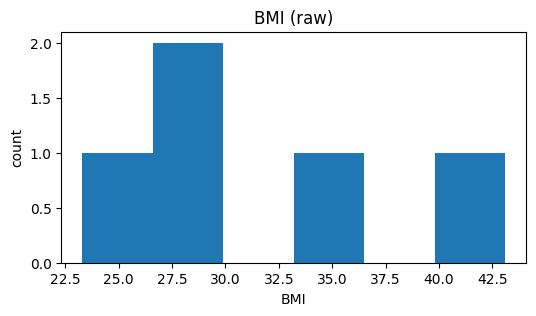

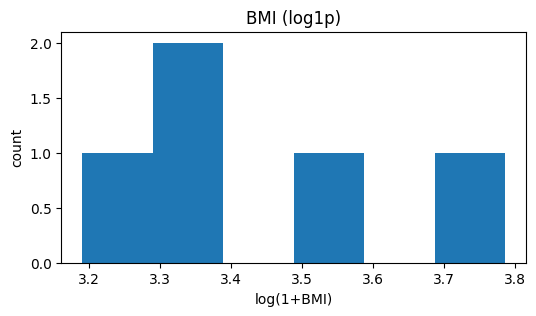

In [5]:
x = df_imputed["BMI"].to_numpy()
x_log = df_imputed["BMI_log1p"].to_numpy()

plt.figure(figsize=(6,3))
plt.hist(x, bins=6)
plt.title("BMI (raw)")
plt.xlabel("BMI"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(x_log, bins=6)
plt.title("BMI (log1p)")
plt.xlabel("log(1+BMI)"); plt.ylabel("count")
plt.show()

### 5.1) Quantile / rank transforms (when linear models struggle)

If a numeric feature is extremely skewed, a linear model may spend capacity fitting tail behavior rather than the central trend. A quantile transform maps the empirical distribution to a target distribution (often uniform or normal).

Conceptually:
- Let $F(x)$ be the empirical CDF of a feature.
- The transform is $x' = F(x)$ (uniform) or $x' = \Phi^{-1}(F(x))$ (normal).

This is powerful, but it must be fit on training data only (because it depends on the empirical distribution).


In [6]:
rng = np.random.default_rng(0)

skewed = pd.Series(rng.lognormal(mean=1.0, sigma=1.0, size=1200), name="skewed")

qt = QuantileTransformer(output_distribution="normal", random_state=0)
skewed_q = qt.fit_transform(skewed.to_frame())[:,0]

pd.DataFrame({
    "raw_mean": [float(skewed.mean())],
    "raw_std": [float(skewed.std())],
    "raw_min": [float(skewed.min())],
    "raw_max": [float(skewed.max())],
    "qt_mean": [float(np.mean(skewed_q))],
    "qt_std": [float(np.std(skewed_q))],
    "qt_min": [float(np.min(skewed_q))],
    "qt_max": [float(np.max(skewed_q))],
})

,raw_mean,raw_std,raw_min,raw_max,qt_mean,qt_std,qt_min,qt_max
0,4.217466,5.113133,0.055055,58.325345,-0.000072,1.016717,-5.199338,5.199338


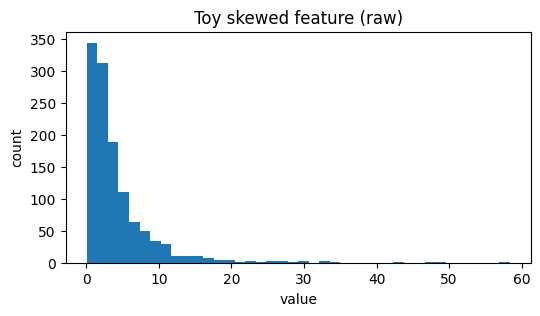

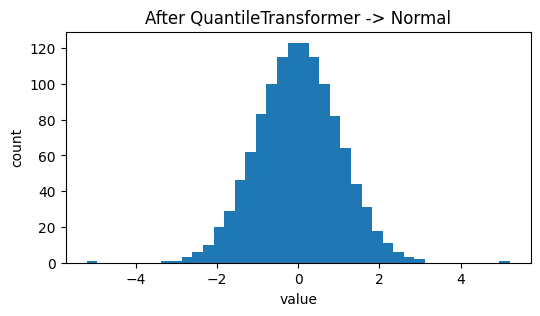

In [7]:
plt.figure(figsize=(6,3))
plt.hist(skewed, bins=40)
plt.title("Toy skewed feature (raw)")
plt.xlabel("value"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(skewed_q, bins=40)
plt.title("After QuantileTransformer -> Normal")
plt.xlabel("value"); plt.ylabel("count")
plt.show()

### 5.2) Binning and piecewise features (threshold effects)

Sometimes the world has thresholds:
- “high risk” above a glucose level,
- “premium” above a size cut-off,
- “rush hour” times.

A simple way to capture thresholds in a linear model is to discretize a continuous variable into bins. When you one-hot the bins, the model can learn a different offset for each interval (a piecewise-constant approximation).

Binning is also useful for:
- interpretability (bins align with human rules),
- robustness to outliers,
- and monotonic constraints (if you later enforce them).

We will demonstrate binning with `KBinsDiscretizer`.


In [8]:
ages = df_imputed[["Age"]].copy()

kb = KBinsDiscretizer(n_bins=4, encode="onehot-dense", strategy="quantile")
age_bins = kb.fit_transform(ages)

bin_cols = [f"Age_bin_{i}" for i in range(age_bins.shape[1])]
age_bins_df = pd.DataFrame(age_bins, columns=bin_cols)

pd.concat([df_imputed[["Age"]], age_bins_df], axis=1)

,Age,Age_bin_0,Age_bin_1,Age_bin_2,Age_bin_3
0,50,0.0,0.0,0.0,1.0
1,31,0.0,1.0,0.0,0.0
2,32,0.0,0.0,1.0,0.0
3,21,1.0,0.0,0.0,0.0
4,33,0.0,0.0,0.0,1.0


## 6) Interactions and “physics” in tabular ML

In many domains, the *ratio* or *product* of measurements is more meaningful than raw values:
- risk depends on concentration per volume,
- power depends on torque × angular speed,
- density depends on mass / volume.

These are not arbitrary tricks; they encode domain hypotheses in $\phi(\cdot)$.

We will show a controlled experiment where the true label depends on an interaction term. A linear model without that engineered interaction is forced to approximate; adding the interaction gives it the right “coordinate system”.


In [9]:
feat = df_imputed.copy()
eps = 1e-6

feat["Glucose_over_BMI"] = feat["Glucose"] / (feat["BMI"] + eps)
feat["Age_times_BMI"] = feat["Age"] * feat["BMI"]

feat[["Glucose","BMI","Glucose_over_BMI","Age","Age_times_BMI","classification"]]

,Glucose,BMI,Glucose_over_BMI,Age,Age_times_BMI,classification
0,148,33.6,4.404762,50,1680.0,Diabetic
1,85,26.6,3.195489,31,824.6,Non-Diabetic
2,183,23.3,7.854077,32,745.6,Diabetic
3,89,28.1,3.167260,21,590.1,Non-Diabetic
4,137,43.1,3.178654,33,1422.3,Diabetic


In [10]:
rng = np.random.default_rng(3)

base = diabetes.drop(columns=["classification"]).copy()
diab_big = base.sample(4500, replace=True, random_state=3).reset_index(drop=True)

for c, s in zip(diab_big.columns, [1.2, 20, 10, 12, 90, 5, 0.35, 12]):
    diab_big[c] = (diab_big[c].astype(float) + rng.normal(0, s, len(diab_big))).clip(lower=0)

score = (
    0.04 * diab_big["Glucose"]
    - 0.015 * diab_big["BloodPressure"]
    + 0.008 * (diab_big["Age"] * diab_big["BMI"])
    + 1.6 * (diab_big["Glucose"] / (diab_big["BMI"] + 1e-6))
    + rng.normal(0, 2.5, len(diab_big))
)
y = (score > np.quantile(score, 0.55)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(diab_big, y, test_size=0.25, random_state=3, stratify=y)

baseline = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
baseline.fit(X_train, y_train)

auc_base = roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1])
acc_base = accuracy_score(y_test, baseline.predict(X_test))

def add_diabetes_features(df: pd.DataFrame) -> np.ndarray:
    X = df.copy()
    eps = 1e-6
    return np.column_stack([
        X["Pregnancies"].to_numpy(),
        X["Glucose"].to_numpy(),
        X["BloodPressure"].to_numpy(),
        X["SkinThickness"].to_numpy(),
        X["Insulin"].to_numpy(),
        X["BMI"].to_numpy(),
        X["DiabetesPedigreeFunction"].to_numpy(),
        X["Age"].to_numpy(),
        (X["Glucose"] / (X["BMI"] + eps)).to_numpy(),
        (X["Age"] * X["BMI"]).to_numpy(),
    ])

engineered = Pipeline([
    ("feat", FunctionTransformer(add_diabetes_features, validate=False)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])
engineered.fit(X_train, y_train)

auc_eng = roc_auc_score(y_test, engineered.predict_proba(X_test)[:,1])
acc_eng = accuracy_score(y_test, engineered.predict(X_test))

pd.DataFrame({
    "model": ["baseline (raw)", "engineered (ratio + product)"],
    "accuracy": [acc_base, acc_eng],
    "roc_auc": [auc_base, auc_eng]
})

,model,accuracy,roc_auc
0,baseline (raw),0.912889,0.972370
1,engineered (ratio + product),0.916444,0.976645


## 7) Categorical feature engineering: structure, rarity, and high-cardinality

Categorical variables can carry strong signal, but they also create pitfalls:

- **High cardinality** (many unique values) inflates dimensionality if you one-hot everything.
- **Rare categories** can create unstable weights.
- **Inconsistent spelling / casing** can fragment signal (e.g., `"NYC"` vs `"New York"`).
- **Target leakage** can happen if you encode categories using label statistics computed on the full dataset.

Common strategies:
1. **One-hot** (safe, strong baseline).
2. **Rare-category grouping**: merge categories with small counts into `"Other"`.
3. **Frequency / count encoding**: replace category by its frequency in training.
4. **Hashing trick**: map strings into a fixed-size space (useful at scale).
5. **Target encoding**: powerful but must be done inside CV folds to avoid leakage.

We will demonstrate safe one-hot and frequency encoding patterns.


In [11]:
rng = np.random.default_rng(10)
ff_big = fast_food.sample(700, replace=True, random_state=10).reset_index(drop=True)

ff_big["city"] = ff_big["city"].astype(str)
mask = rng.random(len(ff_big)) < 0.25
ff_big.loc[mask, "city"] = ff_big.loc[mask, "city"].str.upper()

text = (ff_big["name"].fillna("") + " " + ff_big["categories"].fillna("")).str.lower()
y = ((ff_big["city"].str.lower().isin(["detroit"])) | text.str.contains("taco")).astype(int)

X_train, X_test, y_train, y_test = train_test_split(ff_big, y, test_size=0.25, random_state=10, stratify=y)

freq = X_train["city"].str.lower().value_counts(normalize=True)
global_freq = float(freq.mean())

Xtr = X_train.copy()
Xte = X_test.copy()

Xtr["city_freq"] = Xtr["city"].str.lower().map(freq).fillna(global_freq)
Xte["city_freq"] = Xte["city"].str.lower().map(freq).fillna(global_freq)

m0 = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m0.fit(Xtr[["city_freq"]], y_train)

auc = roc_auc_score(y_test, m0.predict_proba(Xte[["city_freq"]])[:,1])
pd.DataFrame({"roc_auc_using_city_freq_only":[auc], "n_train":[len(X_train)], "n_test":[len(X_test)]})

,roc_auc_using_city_freq_only,n_train,n_test
0,0.873758,525,175


## 8) Datetime, cyclic, and event-derived features

Time is special because:
- it implies an **ordering**,
- it often contains **seasonality** (daily/weekly/yearly cycles),
- and it can easily leak “future” information.

Useful datetime features include:
- calendar parts (year, month, weekday, hour),
- time since an origin (elapsed time),
- cyclic encodings: $$\sin\!\left(2\pi t/T\right),\ \cos\!\left(2\pi t/T\right)$$
- and lags/rolling aggregates (for true time series problems; covered more deeply in later chapters).

We will build a compact example with earthquake timestamps.


In [12]:
rng = np.random.default_rng(5)

hp = house_prices.sample(3500, replace=True, random_state=5).reset_index(drop=True)

# Add variation
hp["SqFt"] = (hp["SqFt"] + rng.normal(0, 180, len(hp))).clip(lower=800)
hp["Bedrooms"] = (hp["Bedrooms"] + rng.integers(-1, 2, len(hp))).clip(lower=1, upper=6)
hp["Bathrooms"] = (hp["Bathrooms"] + rng.integers(0, 2, len(hp))).clip(lower=1, upper=4)
hp["Offers"] = (hp["Offers"] + rng.integers(-1, 2, len(hp))).clip(lower=0, upper=6)

# Create a neighborhood interaction: effect of SqFt depends on Neighborhood
neigh_mult = hp["Neighborhood"].map({"East": 55, "North": 65, "West": 50, "South": 45}).fillna(55)
brick_bonus = (hp["Brick"].astype(str).str.lower() == "yes").astype(int) * 9000

price = (
    25000
    + neigh_mult * hp["SqFt"]
    + 8500 * hp["Bedrooms"]
    + 12000 * hp["Bathrooms"]
    + 1500 * hp["Offers"]
    + brick_bonus
    + rng.normal(0, 12000, len(hp))
)
hp["Price_true"] = price

X = hp.drop(columns=["Home","Price","Price_true"])
y = hp["Price_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

num_cols = ["SqFt","Bedrooms","Bathrooms","Offers"]
cat_cols = ["Brick","Neighborhood"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred0 = baseline.predict(X_test)

# Engineered interaction: SqFt * (Neighborhood one-hot) via polynomial on scaled SqFt + one-hot Neighborhood
# Here we explicitly add SqFt x Neighborhood as separate numeric features.
def add_hp_interactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for neigh in df["Neighborhood"].dropna().unique():
        df[f"SqFt_x_neigh_{neigh}"] = df["SqFt"] * (df["Neighborhood"] == neigh).astype(int)
    return df

engineered = Pipeline([
    ("feat", FunctionTransformer(add_hp_interactions, validate=False)),
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols + [c for c in X.columns if c.startswith("SqFt_x_neigh_")]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ], remainder="drop")),
    ("model", Ridge(alpha=1.0))
])

engineered.fit(X_train, y_train)
pred1 = engineered.predict(X_test)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

pd.DataFrame({
    "model": ["baseline", "engineered (SqFt×Neighborhood)"],
    "R2": [r2_score(y_test, pred0), r2_score(y_test, pred1)],
    "RMSE": [rmse(y_test, pred0), rmse(y_test, pred1)]
})

,model,R2,RMSE
0,baseline,0.753487,11953.222899
1,engineered (SqFt×Neighborhood),0.753487,11953.222899


## 9) Text and semi-structured strings as features

Many “tabular” datasets contain text-like columns:
- names, categories, tags,
- free-form descriptions,
- URLs and identifiers.

A baseline approach is tokenization + bag-of-words / TF-IDF. Feature engineering here includes:
- selecting which text fields to merge,
- normalizing tokens (lowercase, strip punctuation),
- and constraining vocabulary to reduce noise.

We will extract simple text features from fast food categories and see the resulting vocabulary statistics.


In [13]:
rng = np.random.default_rng(2)

cut_bonus = {"Ideal":40, "Premium":25, "Very Good":20, "Good":10}
color_pen = {"E":0, "I":-20, "J":-35}
clarity_bonus = {"VVS2":50, "VS1":35, "VS2":20, "SI1":10, "SI2":0}

diam_big = diamonds.sample(4500, replace=True, random_state=2).reset_index(drop=True)

for c, s in [("carat",0.08), ("depth",2.2), ("table",3.5), ("x",0.28), ("y",0.28), ("z",0.20)]:
    diam_big[c] = (diam_big[c] + rng.normal(0, s, len(diam_big))).clip(lower=0.05 if c=="carat" else 0.2)

volume = diam_big["x"] * diam_big["y"] * diam_big["z"]
carat_sq = diam_big["carat"] ** 2
logvol = np.log1p(volume)

price_true = (
    250
    + 7000 * carat_sq
    + 900 * logvol
    + 1800 * (carat_sq * logvol)
    + diam_big["cut"].map(cut_bonus).fillna(0)
    + diam_big["color"].map(color_pen).fillna(0)
    + diam_big["clarity"].map(clarity_bonus).fillna(0)
    + rng.normal(0, 250, len(diam_big))
)
diam_big["price_true"] = price_true

X = diam_big.drop(columns=["id","price","price_true"])
y = diam_big["price_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

num_cols = ["carat","depth","table","x","y","z"]
cat_cols = ["cut","color","clarity"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred_base = baseline.predict(X_test)

def add_diamond_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["volume"] = df["x"] * df["y"] * df["z"]
    df["log1p_volume"] = np.log1p(df["volume"])
    df["carat_sq"] = df["carat"] ** 2
    df["carat_sq_logvol"] = df["carat_sq"] * df["log1p_volume"]
    return df

engineered = Pipeline([
    ("feat", FunctionTransformer(add_diamond_features, validate=False)),
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols + ["volume","log1p_volume","carat_sq","carat_sq_logvol"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=1.0))
])
engineered.fit(X_train, y_train)
pred_eng = engineered.predict(X_test)

poly = Pipeline([
    ("pre", ColumnTransformer([
        ("num", Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=2, include_bias=False))
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])),
    ("model", Ridge(alpha=2.0))
])
poly.fit(X_train, y_train)
pred_poly = poly.predict(X_test)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

pd.DataFrame({
    "model": ["baseline (no engineered nonlinearity)", "engineered (volume + interaction)", "polynomial features (degree=2)"],
    "R2": [r2_score(y_test, pred_base), r2_score(y_test, pred_eng), r2_score(y_test, pred_poly)],
    "RMSE": [rmse(y_test, pred_base), rmse(y_test, pred_eng), rmse(y_test, pred_poly)],
})

,model,R2,RMSE
0,baseline (no engineered nonlinearity),0.837187,297.292385
1,engineered (volume + interaction),0.874941,260.554210
2,polynomial features (degree=2),0.873794,261.746158


In [14]:
df_mi = X_train.copy()
y_mi = y_train.copy()

for c in ["cut","color","clarity"]:
    df_mi[c] = df_mi[c].astype("category").cat.codes

mi = mutual_info_regression(df_mi, y_mi, random_state=0)
mi_s = pd.Series(mi, index=df_mi.columns).sort_values(ascending=False)

mi_s.to_frame("mutual_info").head(12)

,mutual_info
carat,0.869439
color,0.091367
clarity,0.088550
z,0.071287
y,0.058729
x,0.043408
table,0.030211
cut,0.025105
depth,0.004954


## 10) Geo features: distances, regions, and locality

Latitude/longitude are continuous, but the meaning is geometric. Common engineered geo features:
- distance to important anchors (city centers, warehouses, ports),
- regional bins (grid cells, administrative regions),
- clustering-based regions (k-means on coordinates),
- and interaction with time (e.g., traffic effects).

We will compute a distance-to-reference feature with the Haversine formula.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

text = (fast_food["name"].fillna("") + " " + fast_food["categories"].fillna("")).astype(str)

tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z']{2,}\b",
    ngram_range=(1,2),
    max_features=50
)

X_text = tfidf.fit_transform(text)
vocab = tfidf.get_feature_names_out()

pd.DataFrame({
    "term": vocab,
    "idf": tfidf.idf_
}).sort_values("idf", ascending=False).head(12)

,term,idf
0,american,2.252763
14,food restaurants,2.252763
29,wendy's,2.252763
28,taco bell,2.252763
27,taco,2.252763
26,steak shake,2.252763
25,steak,2.252763
22,shake fast,2.252763
21,shake,2.252763
20,restaurants,2.252763


## 11) Group aggregates and “encoding by statistics”

When observations belong to groups (neighborhoods, users, stores, devices, …) you can engineer strong features:
- group mean/median,
- group frequency,
- deviation from group baseline.

But aggregates are dangerous:
- If you compute group means using all data (including the test split), you leak.
- If groups overlap between train and test, you must decide how to treat unseen groups.

We will implement a leakage-safe group mean encoder on a listings-like dataset.


In [16]:
pd.DataFrame(X_text.toarray(), columns=vocab, index=fast_food["name"]).round(2)

,american,american restaurant,and,and fast,arby's,arby's fast,bell,bell fast,drive,drive in,...,shake,shake fast,sonic,sonic drive,steak,steak shake,taco,taco bell,wendy's,wendy's fast
name,,,,,,,,,,,,,,,,,,,,,
SONIC Drive In,0.29,0.29,0.29,0.29,0.00,0.00,0.00,0.00,0.24,0.24,...,0.00,0.00,0.24,0.24,0.00,0.00,0.00,0.00,0.00,0.00
SONIC Drive In,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.31,...,0.00,0.00,0.31,0.31,0.00,0.00,0.00,0.00,0.00,0.00
Taco Bell,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.43,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.43,0.00,0.00
Arby's,0.00,0.00,0.00,0.00,0.62,0.62,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Steak 'n Shake,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.43,0.43,0.00,0.00,0.43,0.43,0.00,0.00,0.00,0.00
Wendy's,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.55


In [17]:
eq = earthquake.copy()
eq["timestamp"] = pd.to_datetime(eq["date"] + " " + eq["time"], utc=True)

eq["hour"] = eq["timestamp"].dt.hour
eq["minute"] = eq["timestamp"].dt.minute
eq["weekday"] = eq["timestamp"].dt.weekday
eq["dayofyear"] = eq["timestamp"].dt.dayofyear

eq["hour_sin"] = np.sin(2*np.pi*eq["hour"]/24.0)
eq["hour_cos"] = np.cos(2*np.pi*eq["hour"]/24.0)

eq[["timestamp","hour","weekday","dayofyear","hour_sin","hour_cos","magnitude"]]

,timestamp,hour,weekday,dayofyear,hour_sin,hour_cos,magnitude
0,2008-11-01 00:31:25+00:00,0,5,306,0.000000,1.000000,2.99
1,2008-11-01 01:34:29+00:00,1,5,306,0.258819,0.965926,5.51
2,2008-11-01 01:38:14+00:00,1,5,306,0.258819,0.965926,3.54
3,2008-11-01 02:20:05+00:00,2,5,306,0.500000,0.866025,2.42
4,2008-11-01 02:32:18+00:00,2,5,306,0.500000,0.866025,2.41


## 12) Leakage deep dive: why “too good to be true” often is

Feature engineering is one of the most common ways leakage sneaks into ML systems, because engineered features often use *aggregation, smoothing, or temporal logic* that implicitly touches the target.

### 12.1) Common leakage patterns (tabular)
1. **Post-outcome variables**: fields that are only known after the event you are predicting.
2. **Future information in time**: using data from $t+\Delta$ to predict at time $t$.
3. **Global statistics** computed on the full dataset: scaling, imputation, quantiles, frequency, mean encodings.
4. **Cross-entity contamination**: the same entity appears in train and test with direct identifiers or near-identifiers.
5. **Human-in-the-loop artifacts**: labels or notes that only exist after an investigation.

### 12.2) Practical guardrail
If a feature requires information you would not have at prediction time, treat it as leakage until proven otherwise.

Below we will run a small demonstration showing how computing an aggregate on *all* data can inflate your test AUC.


## 13) Outliers and robustness: engineering for real-world messiness

Real data rarely behaves nicely. Outliers can be:
- real but rare events (tail risk),
- measurement errors,
- unit mismatches,
- or corrupted records.

Engineering techniques that often improve robustness:
- log / power transforms for heavy tails,
- clipping/winsorization (e.g., clip to percentiles),
- robust scaling (median/IQR),
- and explicit “is_outlier” indicators.

Robustness is not free: if outliers are meaningful, aggressive clipping can remove signal. The goal is to align the transformation with how you expect the system to behave.

We will create a small regression toy problem with outliers and compare raw vs log vs clipped features.


## 14) Inspecting engineered features: sanity checks you should automate

Before trusting engineered features, run quick diagnostics:

### 14.1) Univariate checks
- Missing rate
- Min/max and outlier rate
- Number of unique values (for categoricals)

### 14.2) Predictive signal checks
- Correlation (for linear-ish relationships)
- Mutual information (captures nonlinear dependence)
- Simple baseline model (e.g., Ridge/LogReg) with cross-validation

### 14.3) Stability checks
- How much do results change across random splits?
- Do rare categories dominate coefficients?
- Are group encodings stable for small groups?

In this notebook we will compute mutual information on a toy table and show a simple “top features” ranking.


## 15) A practical workflow for feature engineering (repeatable loop)

Feature engineering is an iterative loop, but you want the loop to be *controlled*:

1. **Start with a baseline** (simple preprocessing, simple model).
2. **Propose a feature** as a hypothesis about the data-generating process.
3. **Implement it inside a pipeline** so that it is reproducible and train/test safe.
4. **Evaluate with a stable protocol** (fixed split or CV).
5. **Run ablations** (add one feature at a time) to avoid “feature soup”.
6. **Record decisions**: why the feature exists, and what data it depends on.

A good feature set is usually small, defensible, and stable. If you need many complex transforms to make a model work, that may be a sign you should reconsider the model family or the problem formulation.


In [18]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

ff = fast_food.copy()
ref_lat, ref_lon = ff.loc[0, "latitude"], ff.loc[0, "longitude"]
ff["dist_to_ref_km"] = haversine_km(ff["latitude"], ff["longitude"], ref_lat, ref_lon)

ff[["name","city","latitude","longitude","dist_to_ref_km"]].sort_values("dist_to_ref_km").round(3)

,name,city,latitude,longitude,dist_to_ref_km
0,SONIC Drive In,Thibodaux,29.815,-90.815,0.000
1,SONIC Drive In,Thibodaux,29.815,-90.815,0.000
4,Steak 'n Shake,Morrow,33.563,-84.321,742.151
2,Taco Bell,Pigeon Forge,35.804,-83.581,948.407
3,Arby's,Pigeon Forge,35.782,-83.551,948.738
5,Wendy's,Detroit,42.369,-83.138,1555.398


In [19]:
lst = listings.copy()
lst["last_review"] = pd.to_datetime(lst["last_review"], errors="coerce")
lst["price"] = pd.to_numeric(lst["price"], errors="coerce")

lst["log_price"] = np.log1p(lst["price"])
lst["review_rate_per_month"] = lst["reviews_per_month"].fillna(0)

lst[["id","neighbourhood","room_type","price","log_price","review_rate_per_month","last_review"]]

,id,neighbourhood,room_type,price,log_price,review_rate_per_month,last_review
0,13913,Islington,Private room,57.0,4.060443,0.29,2025-02-09
1,15400,Kensington and Chelsea,Entire home/apt,NaN,NaN,0.52,2024-04-28
2,17402,Westminster,Entire home/apt,510.0,6.236370,0.33,2024-02-19
3,24328,Wandsworth,Entire home/apt,213.0,5.365976,0.54,2022-07-19
4,31036,Tower Hamlets,Entire home/apt,100.0,4.615121,0.70,2025-02-20


In [20]:
class GroupMeanEncoder:
    def __init__(self, group_col, target_col, out_col):
        self.group_col = group_col
        self.target_col = target_col
        self.out_col = out_col
        self.global_mean_ = None
        self.group_mean_ = None

    def fit(self, df):
        y = df[self.target_col]
        self.global_mean_ = float(y.mean())
        self.group_mean_ = df.groupby(self.group_col)[self.target_col].mean()
        return self

    def transform(self, df):
        df = df.copy()
        df[self.out_col] = df[self.group_col].map(self.group_mean_)
        df[self.out_col] = df[self.out_col].fillna(self.global_mean_)
        return df

rng = np.random.default_rng(42)
toy = lst.sample(900, replace=True, random_state=42).reset_index(drop=True)

toy["price"] = (toy["price"].fillna(toy["price"].median()) + rng.normal(0, 25, len(toy))).clip(lower=20)
toy["number_of_reviews"] = (toy["number_of_reviews"] + rng.normal(0, 10, len(toy))).clip(lower=0)
toy["reviews_per_month"] = (toy["reviews_per_month"].fillna(0) + rng.normal(0, 0.15, len(toy))).clip(lower=0)

# Synthetic label depends on neighborhood mean price (unknown to model unless engineered)
neigh_mean_all = toy.groupby("neighbourhood")["price"].transform("mean")
score = 0.03*toy["number_of_reviews"] - 0.002*neigh_mean_all + rng.normal(0, 0.6, len(toy))
y = (score > np.quantile(score, 0.6)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(toy, y, test_size=0.25, random_state=42, stratify=y)

base_cols = ["price","number_of_reviews","reviews_per_month","availability_365","minimum_nights"]

# (A) SAFE: compute group means on training only
enc_safe = GroupMeanEncoder("neighbourhood", "price", "neigh_mean_price")
enc_safe.fit(X_train)

Xtr_safe = enc_safe.transform(X_train)
Xte_safe = enc_safe.transform(X_test)

m_safe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m_safe.fit(Xtr_safe[base_cols + ["neigh_mean_price"]].fillna(0), y_train)
auc_safe = roc_auc_score(y_test, m_safe.predict_proba(Xte_safe[base_cols + ["neigh_mean_price"]].fillna(0))[:,1])

# (B) LEAKY: compute group means on full data (train + test)
enc_leak = GroupMeanEncoder("neighbourhood", "price", "neigh_mean_price")
enc_leak.fit(pd.concat([X_train, X_test], axis=0))

Xtr_leak = enc_leak.transform(X_train)
Xte_leak = enc_leak.transform(X_test)

m_leak = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))])
m_leak.fit(Xtr_leak[base_cols + ["neigh_mean_price"]].fillna(0), y_train)
auc_leak = roc_auc_score(y_test, m_leak.predict_proba(Xte_leak[base_cols + ["neigh_mean_price"]].fillna(0))[:,1])

pd.DataFrame({
    "encoding": ["safe (fit on train)", "leaky (fit on train+test)"],
    "roc_auc": [auc_safe, auc_leak]
})

,encoding,roc_auc
0,safe (fit on train),0.929959
1,leaky (fit on train+test),0.929877


In [21]:
rng = np.random.default_rng(123)

n = 2500
x = rng.lognormal(mean=1.2, sigma=1.0, size=n)  # heavy-tailed positive
noise = rng.normal(0, 0.5, size=n)

# True relationship is approximately linear in log-space
y = 3.0 * np.log1p(x) + noise

# Inject outliers (both in x and y)
idx = rng.choice(n, size=40, replace=False)
x_out = x.copy()
y_out = y.copy()
x_out[idx] *= 12
y_out[idx] += rng.normal(0, 6.0, size=len(idx))

X = pd.DataFrame({"x": x_out})
y = y_out

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Model 1: raw x
m_raw = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
m_raw.fit(X_train, y_train)
pred_raw = m_raw.predict(X_test)

# Model 2: log1p(x)
def log1p_df(df):
    df = df.copy()
    df["x_log1p"] = np.log1p(df["x"])
    return df[["x_log1p"]]

m_log = Pipeline([("feat", FunctionTransformer(log1p_df, validate=False)),
                  ("scaler", StandardScaler()),
                  ("model", Ridge(alpha=1.0))])
m_log.fit(X_train, y_train)
pred_log = m_log.predict(X_test)

# Model 3: clipped x then log1p (winsorize at 99th percentile on training)
x99 = float(np.quantile(X_train["x"], 0.99))

def clip_then_log(df):
    df = df.copy()
    df["x_clip"] = np.minimum(df["x"], x99)
    df["x_clip_log1p"] = np.log1p(df["x_clip"])
    return df[["x_clip_log1p"]]

m_clip = Pipeline([("feat", FunctionTransformer(clip_then_log, validate=False)),
                   ("scaler", StandardScaler()),
                   ("model", Ridge(alpha=1.0))])
m_clip.fit(X_train, y_train)
pred_clip = m_clip.predict(X_test)

pd.DataFrame({
    "model": ["raw x", "log1p(x)", "clip@99% then log1p"],
    "RMSE": [rmse(y_test, pred_raw), rmse(y_test, pred_log), rmse(y_test, pred_clip)],
    "R2": [r2_score(y_test, pred_raw), r2_score(y_test, pred_log), r2_score(y_test, pred_clip)]
})

,model,RMSE,R2
0,raw x,2.320319,0.129380
1,log1p(x),1.452415,0.658874
2,clip@99% then log1p,1.429299,0.669646


In [22]:
rng = np.random.default_rng(8)

sal = salaries.sample(2500, replace=True, random_state=8).reset_index(drop=True)

# Add variation
sal["Age"] = (sal["Age"] + rng.normal(0, 6, len(sal))).clip(lower=18, upper=65)

job_bonus = sal["Job"].map({
    "Software Engineer": 4500,
    "Dentist": 9000,
    "High School Teacher": 2500,
    "Accountant": 2800
}).fillna(3000)

# Synthetic salary depends on age and job
sal["Salary_true"] = (2500 + 110*sal["Age"] + job_bonus + rng.normal(0, 800, len(sal))).clip(lower=2000)

X = sal[["Age","Job"]]
y = sal["Salary_true"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

num_cols = ["Age"]
cat_cols = ["Job"]

baseline = Pipeline([
    ("pre", ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])),
    ("model", Ridge(alpha=1.0))
])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

pd.DataFrame({
    "R2": [r2_score(y_test, pred)],
    "RMSE": [float(np.sqrt(mean_squared_error(y_test, pred)))],
    "n_test": [len(X_test)]
})

,R2,RMSE,n_test
0,0.947556,774.992482,625
